In [1]:
import gpflow
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

/home/joshua/Documents/ML/tensorflow_py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


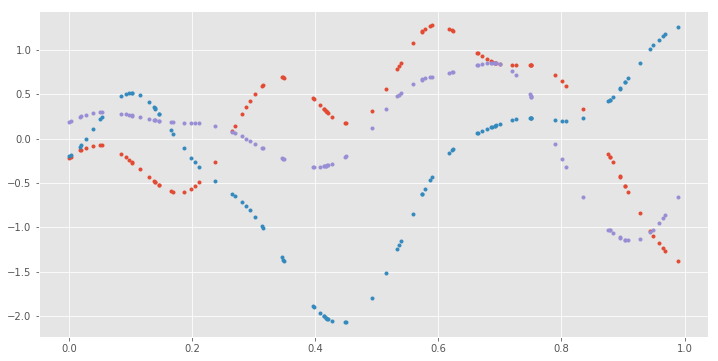

In [2]:
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))
plt.figure(figsize=(12,6))
plt.plot(X, f, '.')
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

In [9]:
f.shape

(100, 3)

In [3]:
m = gpflow.models.SVGP(
    X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(3),
    Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)
m.kern.white.variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004702574], [0.0923385947687978], [0..."
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ..."


In [4]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.774953
  Number of iterations: 181
  Number of functions evaluations: 212


In [5]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])


    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    print(mu.shape)
    p, _ = m.predict_y(xx)

    a3.set_xticks([])
    a3.set_yticks([])


    a3.set_xticks([])
    a3.set_yticks([])

    #for i in range(m.likelihood.num_classes):
    for i in range(mu.shape[1]):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)

    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

(200, 3)


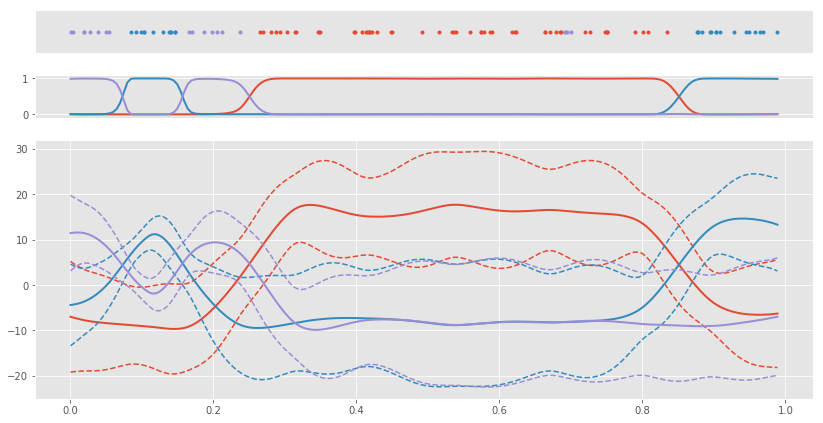

In [6]:
plot(m)

In [7]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,80.57338104929713
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,0.10404192723951129
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01


In [21]:
import keras
from keras.datasets import mnist

xs_train_full = np.genfromtxt("../data/mnist_train_features.csv", delimiter=",")
xs_test_full = np.genfromtxt("../data/mnist_test_features.csv", delimiter=",")

def get_mnist_classes():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return (y_train, y_test)

ys_train_full, ys_test_full = get_mnist_classes()

def _filter(xs, ys, limit_features = 2, limit_classes = 2):
    print("Filtering xs and ys to ", limit_features, " features and ", limit_classes, " classes")
    # note ys are expected to be 1-hot encoded

    # TODO rewrite this more numpy-esque
    filtered_xs = [[] for i in range(limit_classes)]
    filtered_ys = [[] for i in range(limit_classes)]
    for (x,y) in zip(xs, ys):
        for i in range(limit_classes):
            one_hot_class = keras.utils.to_categorical(i, ys.shape[-1])
            #print(one_hot_class, y)
            if np.array_equal(y, one_hot_class):
                filtered_xs[i].append(x[:limit_features])
                filtered_ys[i].append(y[:limit_classes])
                break


    filtered_xs = [np.array(x) for x in  filtered_xs]
    filtered_ys = [np.array(x) for x in  filtered_ys]

    # collapse the per-class matrices into one big matrix
    return (np.vstack(filtered_xs), np.vstack(filtered_ys))


Filtering xs and ys to  1  features and  2  classes


Filtering xs and ys to  1  features and  5  classes


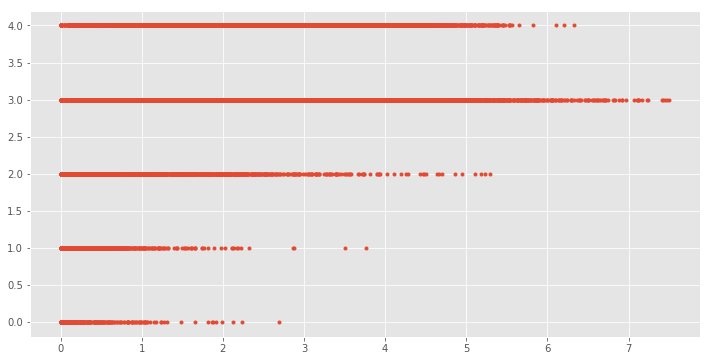

In [30]:
num_classes = 5
xs_train, ys_train = _filter(xs_train_full, ys_train_full, 1, num_classes)
plt.figure(figsize=(12,6))
plt.plot(xs_train, np.argmax(ys_train, axis=1), '.')

In [31]:
m2 = gpflow.models.SVGP(
    xs_train, np.argmax(ys_train, axis=1), kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(num_classes),
    Z=xs_train[::50].copy(), num_latent=num_classes, whiten=True, q_diag=True)
m2.kern.white.variance.trainable = False
m2.feature.trainable = False
m2.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/feature/Z,Parameter,None,(none),False,"(612, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_mu,Parameter,None,(none),True,"(612, 5)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(612, 5)",True,"[[1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1...."


In [32]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m2)

KeyboardInterrupt: 

(200, 2)


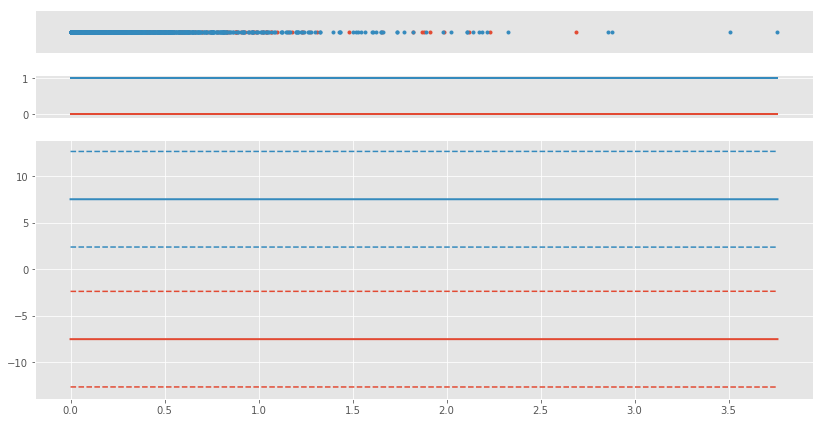

In [28]:
plot(m2)

In [29]:
m2.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,62.63241208890008
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,299.5406254360587
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01
